In [1]:
from model import Network
from data import load_cifar10_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
# load to model
model_config = './model_config/fc2_cocktail_party_instance_wout_bias.json'
checkpoint_path = './checkpoints/121923_fc2_cocktail_party_cifar10_pretraining_wout_bias.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# get val loader
normalize_mean, normalize_std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)
batch_size = 4
data_path = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(normalize_mean, normalize_std),
])

_, val_dataloader = load_cifar10_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([256, 3072]), torch.Size([10, 256])]


In [4]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [5]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(32, 32, 3, 1, 1, 1)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 1.8995347023010254
loss: 0.8788036704063416
loss: 0.7862465977668762
loss: 0.7507825493812561
loss: 0.7505691647529602
loss: 0.7504043579101562
loss: 0.750610888004303
loss: 0.7502849698066711
loss: 0.7506489753723145
loss: 0.7504467964172363
loss: 0.7504922151565552
loss: 0.7506571412086487
loss: 0.7505530714988708
loss: 0.7505476474761963
loss: 0.7504472136497498
loss: 0.7504239082336426
loss: 0.7503676414489746
loss: 0.7504879832267761
loss: 0.7505031824111938
loss: 0.7504636645317078
loss: 0.7503194808959961
loss: 0.7504571676254272
loss: 0.7503634691238403
loss: 0.750187873840332
loss: 0.7503383755683899
loss: 0.7503258585929871


## Estimated images

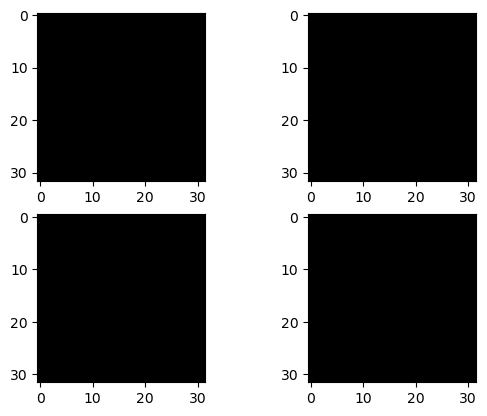

In [13]:
with torch.no_grad():
    unmixing_matrix = unmixing_matrix.detach().to('cpu')
    whitened_gradient = whitened_gradient.detach().to('cpu')
    estimated_img = unmixing_matrix @ whitened_gradient
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(estimated_img, axes.flatten()):
        img = transforms.ToPILImage()(torch.clamp(estimate.reshape(3, 32, 32), min=-1, max=1))
        img = np.asarray(img)
        ax.imshow(img)
    plt.show()

## Original images

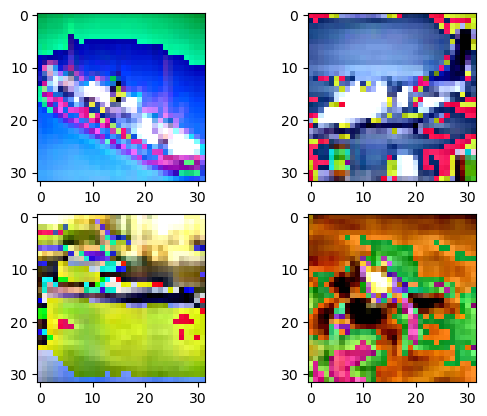

In [19]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(torch.clamp(estimate.reshape(3, 32, 32), min=-1, max=1))
        img = np.asarray(img)
        ax.imshow(img)
    plt.show()